In [171]:
import umap
import os
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import hdbscan
import numpy as np
import re
import emoji
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
import matplotlib.pyplot as plt


In [167]:
def clean_tweet(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.EMOJI_DATA)
    tweet = tweet.replace("#", "").replace("_", " ").replace("RT ", "").replace('&amp;', '&') #Remove hashtag sign but keep the text
    return tweet

def clean_tweet_df(row):
    tweet = row["full_text"]
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.EMOJI_DATA)
    tweet = tweet.replace("#", "").replace("_", " ").replace("RT ", "").replace('&amp;', '&') #Remove hashtag sign but keep the text
    return tweet



20       China suspends import of coal from North Korea...
21           It's time Tsai stopped playing little tricks.
22       'Belt and Road' gives lift to China's ties wit...
23       China and the Middle East - a rapidly changing...
24        Video: Why does Japanese embassy act like a spy?
                               ...                        
27934    The meeting between Chinese President Xi Jinpi...
27935    Xi on perceiving, conceiving China-U.S. relati...
27936    Friendly groups in the United States gave a we...
27937    The United Nations Security Council adopted a ...
27938    Biden sees Xi off at Filoli Estate after talks...
Length: 19096, dtype: object

In [23]:
tweets_csv = pd.read_csv("../../tweets.csv")
tweets_csv["cleaned_full_text"] = tweets_csv.apply(clean_tweet_df, axis=1)
tweets_csv_en = tweets_csv[tweets_csv["lang"] == "en"]

In [19]:
texts = tweets_csv_en["full_text"]
tweets = []
for t in texts:
    tweets.append(clean_tweet(t))

In [20]:
if os.path.exists("./topic.pkl"):
    topic_model = BERTopic.load("./topic.pkl", embedding_model="all-mpnet-base-v2")
else:
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    representation_model = KeyBERTInspired()
    vectorizer_model = CountVectorizer(stop_words="english")
    topic_model = BERTopic(embedding_model="all-mpnet-base-v2", vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model)
    topics, probs = topic_model.fit_transform(tweets)
    new_topics = topic_model.reduce_outliers(tweets, topics)
    topic_model.update_topics(tweets, topics=new_topics)
    topic_model.save("./topic.pkl", save_embedding_model=False)
info = topic_model.get_topic_info()

In [169]:
# topic_names = [topic_model.get_topic_info(t)["Name"] for t in topics]
# topic_names = [t.values[0] for t in topic_names]
# tweets_csv_en["topic"] = topic_names
# tweets_csv_merged = tweets_csv.merge(tweets_csv_en[["id_str", "topic"]], on=["id_str"], how="outer")
tweets_csv_merged = pd.read_csv("tweets_with_topic.csv")
tweets_csv_merged["cleaned_full_text"] = tweets_csv_merged.apply(clean_tweet_df, axis=1)


In [32]:
def get_users(text, df):
    similar_topics, similarity = topic_model.find_topics(text, top_n=3)
    topic_names = [topic_model.get_topic_info(t)["Name"] for t in similar_topics]
    topic_names = [t.values[0] for t in topic_names]
    return df[df["topic"].isin(topic_names)]

In [71]:
similar_topics, similarity = topic_model.find_topics("russia", top_n=5)
russian_topics = []
for st in similar_topics:
    russian_topics.append(topic_model.get_topic_info(st)["Representation"].values[0])
russian_topics = list(set(itertools.chain(*russian_topics)))

In [99]:
russian_topics

['arabia',
 'egypt',
 'met',
 'afghanistan',
 'croatian',
 'russian',
 'decided',
 'intl',
 'russia',
 'kabul',
 'crisis',
 'putin',
 'saudi',
 'iraq',
 'ukraine',
 'zelenskyy',
 'croatia',
 'afg',
 'members',
 'ethiopia',
 'volodymyr',
 'ukrainian',
 'uae',
 'poland',
 'troops',
 'ambassador',
 'qi',
 'moscow',
 'vladimir',
 'chaos',
 'police',
 'brics',
 'withdrawal',
 'syria',
 'danial',
 'czech',
 'military',
 'phone',
 'position',
 'coorperation',
 'iran',
 'bamiyan',
 'patrol',
 'ukrainewar',
 'angry',
 'argentina']

In [100]:
israel_topics

['arabia',
 'egypt',
 'toll',
 'hamas',
 'acts',
 'palestinian',
 'decided',
 'saudi',
 'harm',
 'civilians',
 'erdogan',
 'shifa',
 'members',
 'ethiopia',
 'uae',
 'killed',
 'israel',
 'al',
 'palestine',
 'envoy',
 'gaza',
 'palestinians',
 'humanitarian',
 'israeli',
 'germany',
 'brics',
 'strikes',
 'israelis',
 'argentina',
 'forces',
 'olaf',
 'zhai',
 'hospital',
 'scholz',
 'refugee',
 'iran',
 'death',
 'conflict',
 'condemns',
 'un']

In [72]:
similar_topics, similarity = topic_model.find_topics("israel", top_n=5)
israel_topics = []
for st in similar_topics:
    israel_topics.append(topic_model.get_topic_info(st)["Representation"].values[0])
israel_topics = list(set(itertools.chain(*israel_topics)))

In [76]:
from sklearn.metrics.pairwise import cosine_similarity

In [83]:
russian_topics_emb = topic_model.embedding_model.embed_words(russian_topics)
israel_topics_emb = topic_model.embedding_model.embed_words(israel_topics)
matrix = cosine_similarity(russian_topics_emb, israel_topics_emb)

In [86]:
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))

In [101]:
maxs = k_largest_index_argsort(matrix, 500)

In [102]:
for x, y in maxs:
    print(russian_topics[x], israel_topics[y])

ethiopia ethiopia
argentina argentina
brics brics
uae uae
saudi saudi
arabia arabia
egypt egypt
members members
decided decided
iran iran
saudi arabia
arabia saudi
egypt arabia
arabia egypt
poland germany
arabia israel
russia germany
syria israel
uae saudi
saudi uae
egypt iran
iran egypt
arabia uae
uae arabia
afghanistan arabia
egypt israel
syria arabia
iran israel
iraq iran
argentina germany
syria palestine
afghanistan iran
troops civilians
arabia iran
iran arabia
iraq israel
syria egypt
afghanistan egypt
syria iran
iraq arabia
egypt uae
uae egypt
croatia argentina
arabia palestine
syria gaza
ethiopia egypt
egypt ethiopia
iraq egypt
russia egypt
egypt saudi
saudi egypt
ukraine germany
syria ethiopia
russia iran
russia argentina
afghanistan ethiopia
syria saudi
iran saudi
saudi iran
iraq saudi
putin erdogan
ethiopia arabia
arabia ethiopia
iraq palestine
afghanistan saudi
military civilians
afghanistan germany
croatia germany
ukrainian israeli
ukraine argentina
iraq uae
afghanistan isra

In [156]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
tweets = get_users("israel war", tweets_csv_merged)["full_text"].values
scores = classifier(list(tweets))
dfs = pd.concat([pd.DataFrame(s) for s in scores], ignore_index=True, sort=False)
scores = dfs.groupby(['label']).sum()
scores["score"] = scores["score"] / len(tweets)

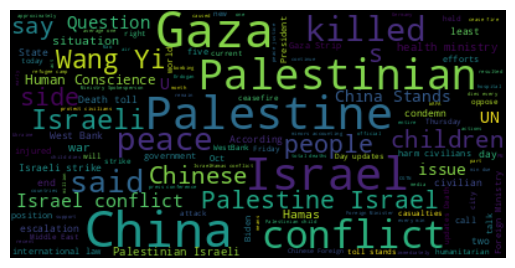

In [175]:
from wordcloud import WordCloud
tweets = "".join(get_users("israel war", tweets_csv_merged)["cleaned_full_text"].values)
wordcloud = WordCloud(max_font_size=40).generate(tweets)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()